In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function

In [10]:
def sigmoid_interpolation(start, end, steps):
    """
    Interpolates between start and end values using a sigmoid function over a specified number of steps.
    """
    x = np.linspace(-6, 6, steps)  # Range chosen to cover the significant transition of the sigmoid curve
    y = expit(x)  # Sigmoid function
    interpolated_values = start + (end - start) * y
    return interpolated_values

In [11]:
# Define file paths and corresponding new column names
files_and_columns = {
    '../data/sst_SanPablo.csv': 'sst_SanPablo',
    '../data/sst_Alameda.csv': 'sst_Alameda',
    '../data/sst_SanGregorio.csv': 'sst_SanGregorio',
    '../data/sst_Farallones.csv': 'sst_Farallones'
}

# Initialize an empty list to hold DataFrames
dfs = []

# Process each file
for file_path, new_col_name in files_and_columns.items():
    # Load CSV file into DataFrame
    df = pd.read_csv(
        file_path,
        parse_dates=['time'],
        index_col='time'
    )
    # Select only the 'sst_at_location' column and rename it
    df = df[['sst_at_location']].rename(columns={'sst_at_location': new_col_name})
    # Append the processed DataFrame to the list
    dfs.append(df)

# Combine all DataFrames on the time index
all_data = pd.concat(dfs, axis=1)

In [12]:
# Define file paths and corresponding new column names
files_and_columns = {
    '../data/sst_SanPablo.csv': 'sst_SanPablo',
    '../data/sst_Alameda.csv': 'sst_Alameda',
    '../data/sst_SanGregorio.csv': 'sst_SanGregorio',
    '../data/sst_Farallones.csv': 'sst_Farallones'
}

# Initialize an empty list to hold DataFrames
dfs = []

# Process each file
for file_path, new_col_name in files_and_columns.items():
    # Load CSV file into DataFrame
    df = pd.read_csv(
        file_path,
        parse_dates=['time'],
        index_col='time'
    )
    # Select only the 'sst_at_location' column and rename it
    df = df[['sst_at_location']].rename(columns={'sst_at_location': new_col_name})
    # Append the processed DataFrame to the list
    dfs.append(df)

# Combine all DataFrames on the time index
all_data = pd.concat(dfs, axis=1)
all_data.head()

sst_SanPablo  sst_Alameda  sst_SanGregorio  \
time                                                              
2023-06-21 09:00:00       290.863      290.524          288.308   
2023-06-22 09:00:00       290.279      290.487          288.194   
2023-06-23 09:00:00       290.266      290.465          288.439   
2023-06-24 09:00:00       289.736      290.050          288.635   
2023-06-25 09:00:00       290.546      290.577          288.705   

                     sst_Farallones  
time                                 
2023-06-21 09:00:00         286.789  
2023-06-22 09:00:00         286.620  
2023-06-23 09:00:00         286.240  
2023-06-24 09:00:00         285.941  
2023-06-25 09:00:00         286.207

In [13]:
# Normalize each column to the range [0, 1]
normalized_data = (all_data - all_data.min()) / (all_data.max() - all_data.min())

In [14]:
# Define the desired frequency for resampling
desired_freq = '30min'  # 30-minute intervals

# Initialize an empty DataFrame to hold interpolated data
interpolated_data = pd.DataFrame()

# Process each column separately
for column in normalized_data.columns:
    # Drop NaN values to work with actual data points
    data = normalized_data[column].dropna()

    # Create a new Series to hold the interpolated series
    interpolated_series = pd.Series(dtype=float)

    # Iterate over each pair of consecutive data points
    for i in range(len(data) - 1):
        start_time = data.index[i]
        end_time = data.index[i + 1]
        start_value = data.iloc[i]
        end_value = data.iloc[i + 1]

        # Generate timestamps between start and end at the desired frequency
        timestamps = pd.date_range(start=start_time, end=end_time, freq=desired_freq)[1:-1]

        # Perform sigmoid interpolation
        interpolated_values = sigmoid_interpolation(start_value, end_value, len(timestamps))

        # Create a temporary series with interpolated values
        temp_series = pd.Series(interpolated_values, index=timestamps)

        # Concatenate the temporary series to the interpolated series
        interpolated_series = pd.concat([interpolated_series, temp_series])

    # Combine with original data
    interpolated_series = pd.concat([interpolated_series, data])

    # Sort the index to maintain chronological order
    interpolated_series = interpolated_series.sort_index()

    # Add the interpolated series to the DataFrame
    interpolated_data[column] = interpolated_series

# Resample the interpolated data to ensure consistent 30-minute intervals
interpolated_data = interpolated_data.resample(desired_freq).mean()

# Forward-fill any remaining NaN values
interpolated_data = interpolated_data.ffill()


# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

trimmed_data.tail()

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_30282/2778642787.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_30282/2778642787.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_30282/2778642787.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated

sst_SanPablo  sst_Alameda  sst_SanGregorio  \
2024-06-20 18:30:00      0.019635     0.048959         0.123555   
2024-06-20 19:00:00      0.019243     0.048601         0.123443   
2024-06-20 19:30:00      0.018912     0.048298         0.123348   
2024-06-20 20:00:00      0.018633     0.048044         0.123269   
2024-06-20 20:30:00      0.018397     0.047829         0.123201   

                     sst_Farallones  
2024-06-20 18:30:00        0.134719  
2024-06-20 19:00:00        0.134706  
2024-06-20 19:30:00        0.134694  
2024-06-20 20:00:00        0.134685  
2024-06-20 20:30:00        0.134677

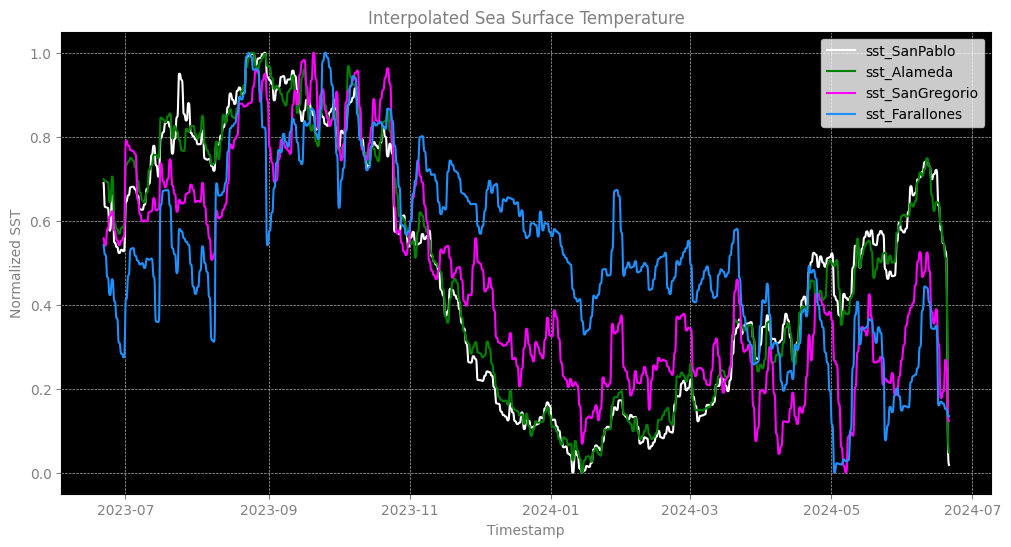

In [15]:
# Define colors for each location
colors = {
    'sst_SanPablo': 'white',
    'sst_Alameda': 'green',
    'sst_SanGregorio': 'magenta',
    'sst_Farallones': 'dodgerblue'
}

# Plotting
plt.figure(figsize=(12, 6))
for column in trimmed_data.columns:
    plt.plot(trimmed_data.index, trimmed_data[column], color=colors[column], label=column)

plt.xlabel('Timestamp', color='grey')
plt.ylabel('Normalized SST', color='grey')
plt.title('Interpolated Sea Surface Temperature', color='grey')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='grey')
plt.show()

In [16]:
trimmed_data.to_csv('../data/sst_all.csv', index = True)